# DeViSE
We are familiar with how word embeddings map words to an N-dimensional vector space, logically speaking we should be able to do the same with images (assume that we are speaking of images that have one principle object). Hence, if we can map said words and images to the same vector space, we should be able to find interesting relationships.

This deep visual-semantic embedding model (DeViSE) leverages textual data to learn semantic relationships between labels, and explicitly maps images into a rich semantic embedding space.
https://papers.nips.cc/paper/5204-devise-a-deep-visual-semantic-embedding-model

In [2]:
from fastai.vision import *

## Data

We work with a subset of imagenet since the full version is too large to handle.

In [3]:
# !wget http://files.fast.ai/data/imagenet-sample-train.tar.gz

In [103]:
path = Path.home()/'.fastai/data/imagenet/imagenet-subset'

### Inputs: precomputed activations

We will build a model on a subset of ImageNet, so we will compute once and for all the activations for the whole training and validation set.

In [5]:
src = (ImageList.from_folder(path)
          .split_by_rand_pct(0.1)
          .label_from_func(lambda x: x.parent.name))

In [6]:
data = src.presize(size=224).databunch(bs=256).normalize(imagenet_stats)

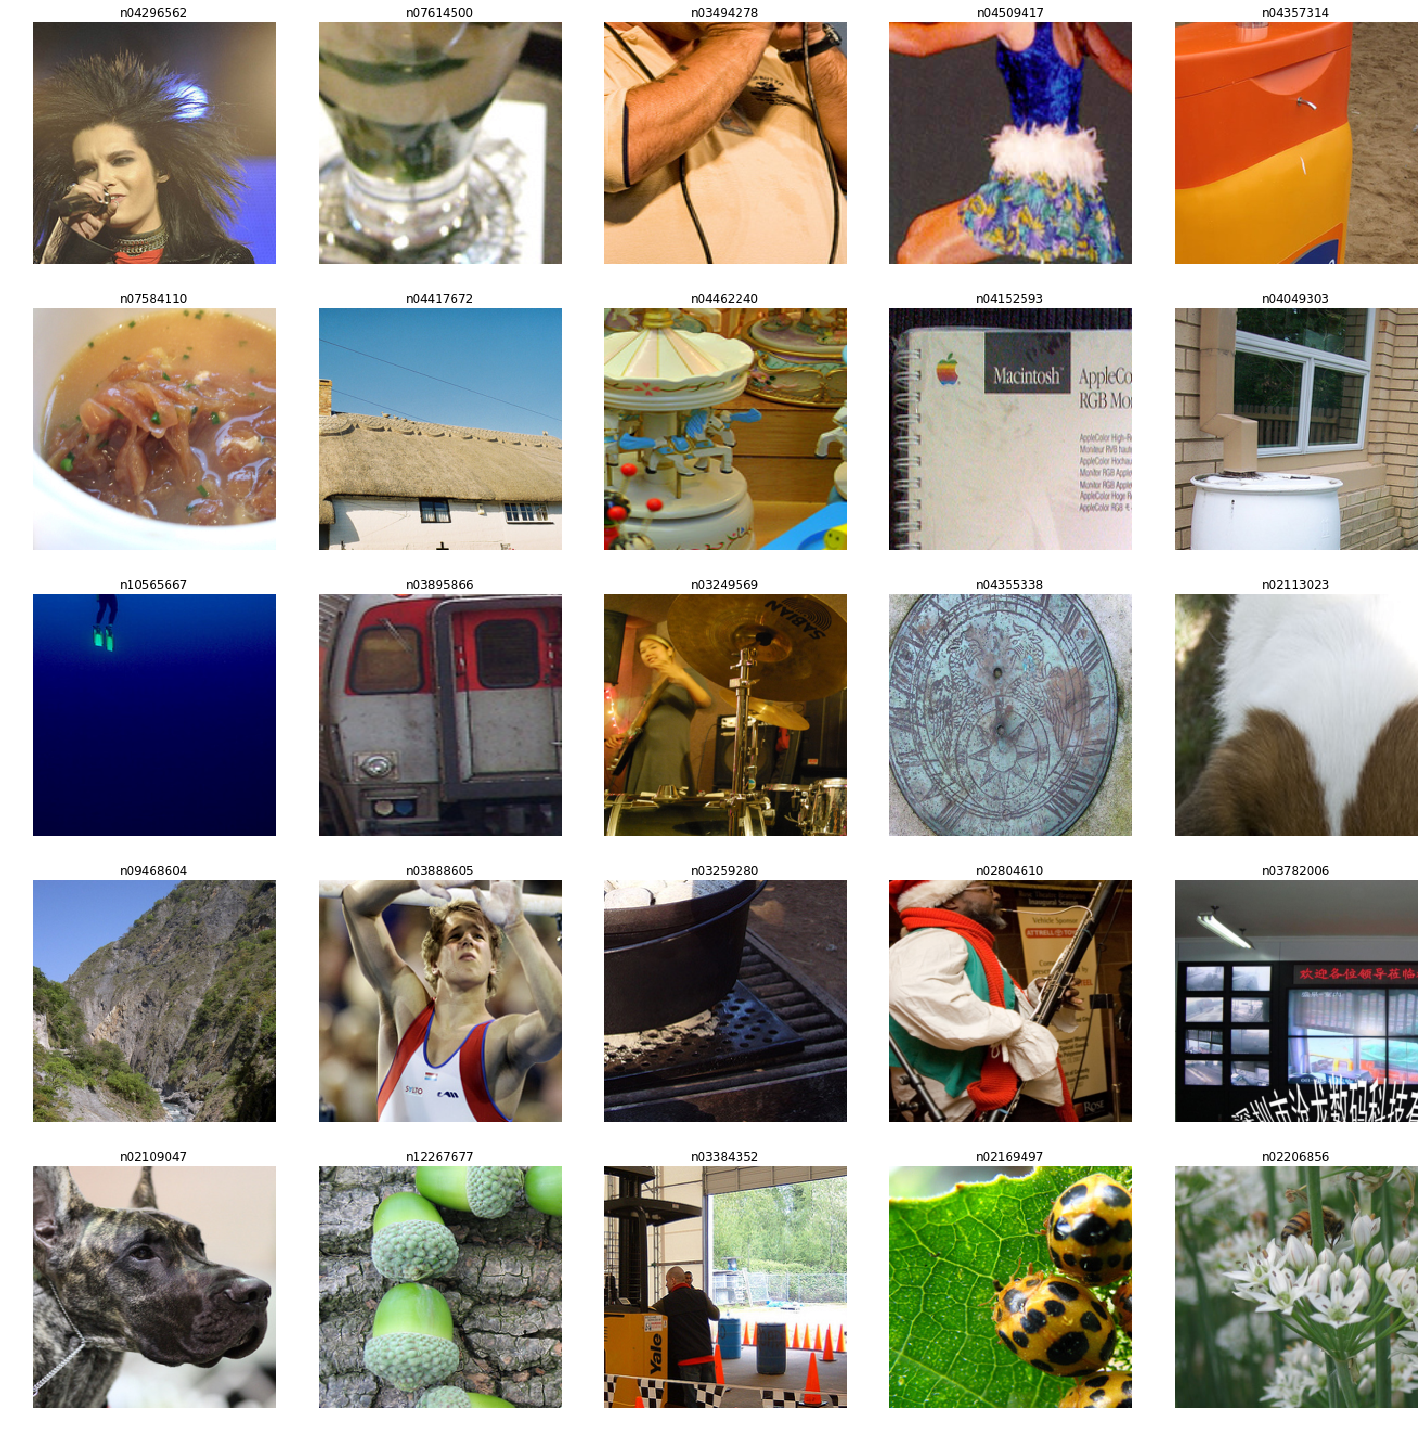

In [7]:
data.show_batch()

We obtain our activations from a resnet-50 model.

In [17]:
body = create_body(models.resnet50)
layers = list(body.children())
# layers += [AdaptiveConcatPool2d(), Flatten()]   
body = nn.Sequential(*layers).to(defaults.device)

We will use bcolz to store our activations in an array that's saved to memory (RAM isn't big enough).

In [11]:
# !pip install -U bcolz

In [29]:
import bcolz

In [24]:
tmp_path = path/'tmp'

Those functions will store the precomputed activations in `tmp_path`.

In [15]:
def precompute_activations_dl(dl, model, path:Path, force:bool=False):
    body.eval()
    if os.path.exists(path) and not force: return
    arr = bcolz.carray(np.zeros((0,4096), np.float32), chunklen=1, mode='w', rootdir=path)
    with torch.no_grad():
        for x,y in progress_bar(dl):
            z = body(x)
            arr.append(z.cpu().numpy())
            arr.flush()

In [16]:
def precompute_activations(data, model, path:Path, force:bool=False):
    os.makedirs(path, exist_ok=True)
    #Use fix_dl so there's no shuffling
    precompute_activations_dl(data.fix_dl,   model, path/'train', force=force) 
    precompute_activations_dl(data.valid_dl, model, path/'valid', force=force)

In [17]:
precompute_activations(data, body, tmp_path)

In [26]:
(tmp_path/'valid').ls()

[PosixPath('/home/jupyter/.fastai/data/imagenet/imagenet-subset/tmp/valid/data'),
 PosixPath('/home/jupyter/.fastai/data/imagenet/imagenet-subset/tmp/valid/__attrs__'),
 PosixPath('/home/jupyter/.fastai/data/imagenet/imagenet-subset/tmp/valid/meta')]

Save the labels and the filenames in the same order as our activations.

In [18]:
np.save(tmp_path/'trn_lbl.npy', data.train_ds.y.items)
np.save(tmp_path/'val_lbl.npy', data.valid_ds.y.items)
save_texts(tmp_path/'classes.txt', data.train_ds.classes)

In [19]:
np.save(tmp_path/'trn_names.npy', data.train_ds.x.items)
np.save(tmp_path/'val_names.npy', data.valid_ds.x.items)

To load our precomputed activations, we'll use the following `ItemList`

In [30]:
class BcolzItemList(ItemList):
    def __init__(self, path, **kwargs):
        self.arr = bcolz.open(path)
        super().__init__(range(len(self.arr)), **kwargs)
    
    def get(self, i): return self.arr[i]

In [31]:
src = ItemLists(path, BcolzItemList(path/'tmp'/'train'), BcolzItemList(path/'tmp'/'valid'))

### Targets: Word Vectors

We build a regression model that has to predict an N-dimensional vector from the image features. We need to associate a word vector to each one of our ~~1000~~ 774 classes.

In [42]:
classes = loadtxt_str(tmp_path/'classes.txt')

In [29]:
classes, len(classes)

(array(['n01440764', 'n01443537', 'n01491361', 'n01494475', ..., 'n13044778', 'n13054560', 'n13133613', 'n15075141'],
       dtype='<U9'), 774)

The labels in imagenet are codes that come from [wordnet](https://wordnet.princeton.edu/).

In [45]:
WORDNET = 'classids.txt'
download_url(f'http://files.fast.ai/data/{WORDNET}', path/'tmp'/WORDNET)

In [46]:
class_ids = loadtxt_str(path/'tmp'/WORDNET)
class_ids = dict([l.strip().split() for l in class_ids])

In [47]:
named_classes = [class_ids[c] for c in classes]
named_classes[:10]

['tench',
 'goldfish',
 'tiger_shark',
 'hammerhead',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch']

Usually we want our model to predict the correct label for each image, this time we want it instead to predict a N-dimensional vector that corresponds to its label.

We use fastText for word embeddings. (it requires a download of 7GB+ though, think twice before proceeding)

In [ ]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

In [40]:
import fastText as ft
en_vecs = ft.load_model(str(Path(os.getcwd())/'cc.en.300.bin'))

A lot of our classes are actually composed of several words separated by a `_`. The pretrained word vectors from fastText won't know them directly, but it can still compute a word vector to represent them:

In [56]:
vec_dog = en_vecs.get_sentence_vector('dog')
vec_lab = en_vecs.get_sentence_vector('labrador')
vec_gor = en_vecs.get_sentence_vector('golden retriever')
vec_ban = en_vecs.get_sentence_vector('banana')

To check if two word vectors are close or not, we use cosine similarity. Dogs should be similar to each other but different from a fruit.

In [57]:
F.cosine_similarity(tensor(vec_dog[None]), tensor(vec_lab[None]))

tensor([0.6715])

In [58]:
F.cosine_similarity(tensor(vec_dog[None]), tensor(vec_ban[None]))

tensor([0.1956])

In [59]:
F.cosine_similarity(tensor(vec_lab[None]), tensor(vec_ban[None]))

tensor([0.2677])

In [60]:
F.cosine_similarity(tensor(vec_dog[None]), tensor(vec_gor[None]))

tensor([0.4356])

In [61]:
F.cosine_similarity(tensor(vec_lab[None]), tensor(vec_gor[None]))

tensor([0.5824])

So let's grab all the word vectors for all our classes:

In [48]:
vecs = []
for n in named_classes:
    vecs.append(en_vecs.get_sentence_vector(n.replace('_', ' ')))

Then we label each feature map with the word vector of its target.

In [49]:
train_labels = np.load(tmp_path/'trn_lbl.npy')
valid_labels = np.load(tmp_path/'val_lbl.npy')
train_vecs = [vecs[l] for l in train_labels]
valid_vecs = [vecs[l] for l in valid_labels]

We use our custom `BcolzItemList` to gather the data:

In [50]:
src = ItemLists(path, BcolzItemList(tmp_path/'train'), BcolzItemList(tmp_path/'valid'))
src = src.label_from_lists(train_vecs, valid_vecs, label_cls=FloatList)

In [51]:
data = src.databunch(bs=512, num_workers=16)

Since we have already saved the activations from the 'body' of a resnet-50 model, we now need a 'head' to do the regression.

In [52]:
model = create_head(4096, data.c, lin_ftrs = [1024], ps=[0.2,0.2])
model = nn.Sequential(*list(model.children())[2:])

In [53]:
model

Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.2)
  (2): Linear(in_features=4096, out_features=1024, bias=True)
  (3): ReLU(inplace)
  (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.2)
  (6): Linear(in_features=1024, out_features=300, bias=True)
)

In [54]:
def cos_loss(inp,targ): return 1 - F.cosine_similarity(inp,targ).mean()

In [55]:
learn = Learner(data, model, loss_func=cos_loss)

In [56]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-02
Min loss divided by 10: 3.31E-01


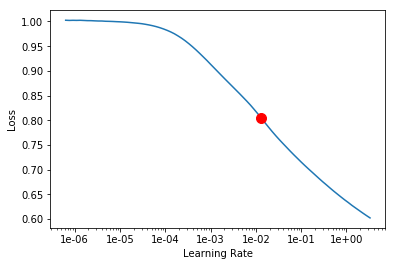

In [57]:
learn.recorder.plot(suggestion=True)

In [87]:
learn.fit_one_cycle(15,3e-2)

In [88]:
learn.save('final')

In [63]:
learn.model.eval()
preds = []
with torch.no_grad():
    for x,y in progress_bar(learn.data.fix_dl):
        preds.append(learn.model(x).cpu().numpy())
    for x,y in progress_bar(learn.data.valid_dl):
        preds.append(learn.model(x).cpu().numpy())

In [64]:
preds = np.concatenate(preds, 0)

In [93]:
np.save(path/'preds.npy', preds)

### Looking at predicted tags in image classes

Now we will check, for one given image, what are the word vectors that are the closest to it. We use a library `nmslib` to do the search.

Non-Metric Space Library (NMSLIB) is an efficient cross-platform similarity search library and a toolkit for evaluation of similarity search methods. 

In [94]:
# !pip install nmslib

    100% |████████████████████████████████| 256kB 38.9MB/s ta 0:00:01
  Stored in directory: /home/jupyter/.cache/pip/wheels/c5/ce/c5/ea826b646b40720375cd5fcf3ff893434c041d64eb457b9e6a
Successfully built nmslib


For more details, check the Python documentation for `nmslib`.

In [59]:
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

### Matching predicted vectors to label vectors

We first run a search among the word vectors that are labels of the dataset:

In [60]:
nn_classes = create_index(vecs)

In [65]:
valid_preds = preds[-len(data.valid_ds):]
valid_names = np.load(tmp_path/'val_names.npy')

In [80]:
idxs,dists = get_knns(nn_classes, valid_preds)

Text(0.5, 0.98, 'Top 3 Predictions\n Actual Class\n')

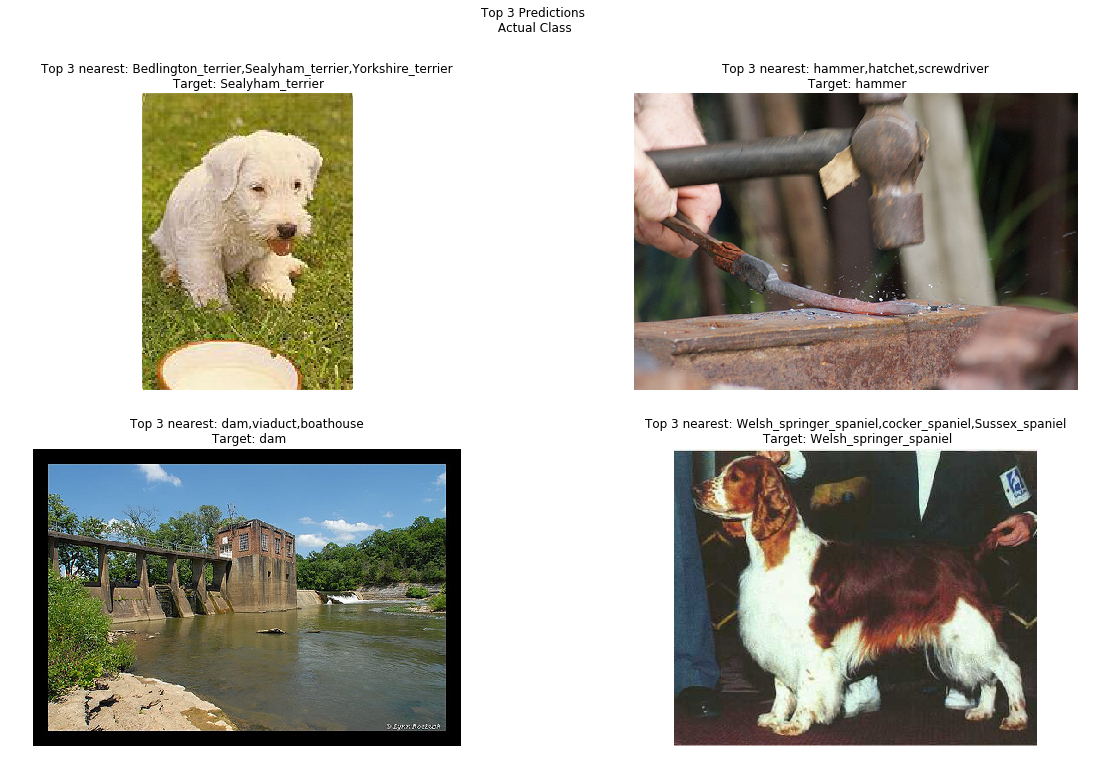

In [81]:
ks = np.random.randint(len(valid_preds),size=4)
_,axs = plt.subplots(2,2,figsize=(20,12))
for k,ax in zip(ks, axs.flatten()):
    open_image(valid_names[k]).show(ax = ax)
    title = 'Top 3 nearest: '
    title += ','.join([class_ids[classes[i]] for i in idxs[k][:3]])
    title += f'\n Target: {class_ids[classes[valid_labels[k]]]}'
    ax.set_title(title)
plt.suptitle('Top 3 Predictions\n Actual Class\n')


### Matching predicted vectors to all vectors in WordNet

Previously we were just comparing the predicted vectors to the vectors assigned to the labels of Imagenet, now we search the space of vectors corresponding to <strong>ALL</strong> words in WordNet.

In [68]:
words,wn_vecs = [],[]
for k,n in class_ids.items():
    words.append(n)
    wn_vecs.append(en_vecs.get_sentence_vector(n.replace('_', ' ')))

In [69]:
nn_wvs = create_index(wn_vecs)

In [78]:
idxs,dists = get_knns(nn_wvs, valid_preds)

Text(0.5, 0.98, 'Top 3 Predictions\n Actual Class\n')

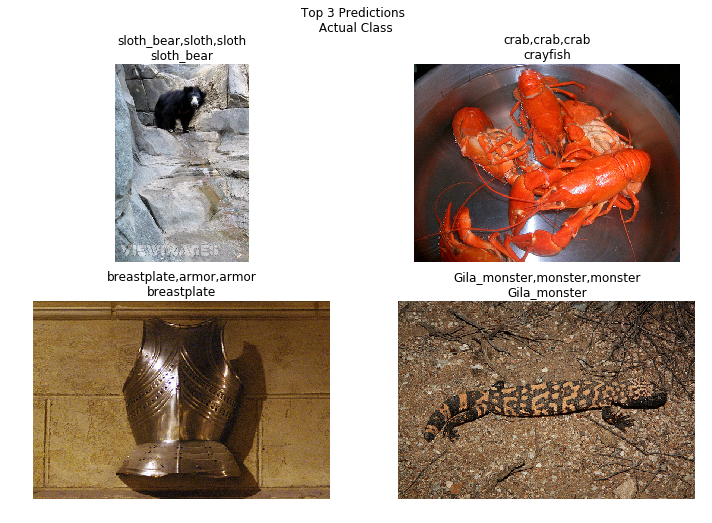

In [79]:
ks = np.random.randint(len(valid_preds),size=4)

fig,axs = plt.subplots(2,2,figsize=(12,8))
for k,ax in zip(ks, axs.flatten()):
    open_image(valid_names[k]).show(ax = ax)
    title = ','.join([words[i] for i in idxs[k][:3]])
    title += f'\n{class_ids[classes[valid_labels[k]]]}'
    ax.set_title(title)
    
plt.suptitle('Top 3 Predictions\n Actual Class\n')


### Text -> Image 

We can use the reverse approach: feed a word vector and find the image activations that match it the closest:

In [88]:
all_names = np.hstack((np.load(tmp_path/'trn_names.npy'), np.load(tmp_path/'val_names.npy')))

In [90]:
nn_preds = create_index(preds)

In [91]:
len(all_names),len(nn_preds)

(19439, 19439)

In [92]:
def show_imgs_from_text(text):
    vec = en_vecs.get_sentence_vector(text)
    idxs,dists = get_knn(nn_preds, vec)
    _,axs = plt.subplots(2,2,figsize=(12,8))
    for i,ax in zip(idxs[:4], axs.flatten()):
        open_image(all_names[i]).show(ax = ax)

'Boat' isn't a label in ImageNet, yet if we try to search for images that have vectors most similar to 'boat' we get this!

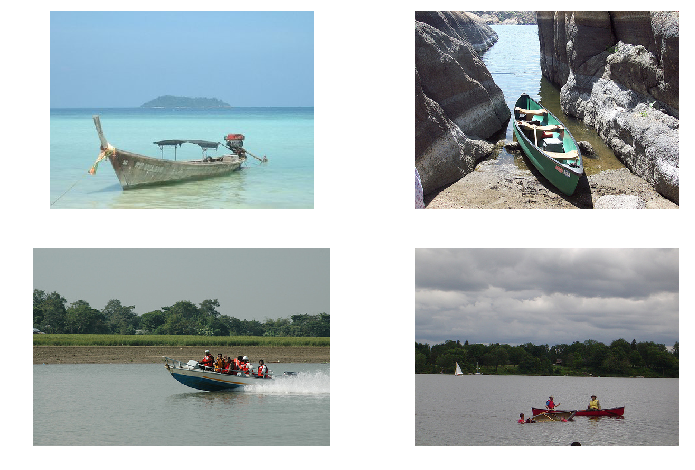

In [93]:
show_imgs_from_text('boat')

What about 'motor boat'?

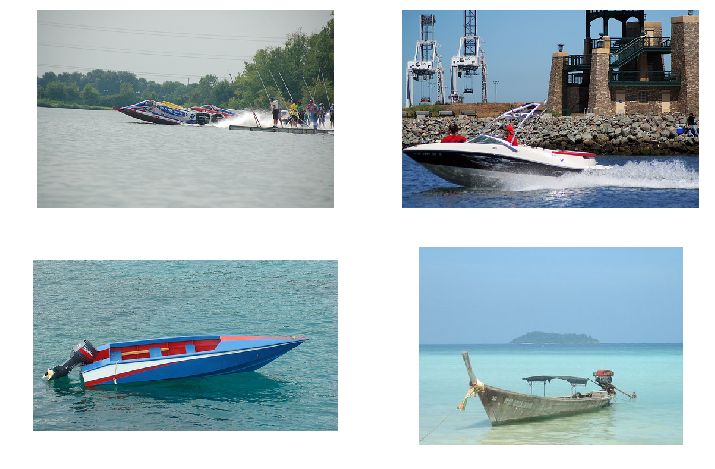

In [99]:
show_imgs_from_text('motor boat')

And even 'sail boat'!

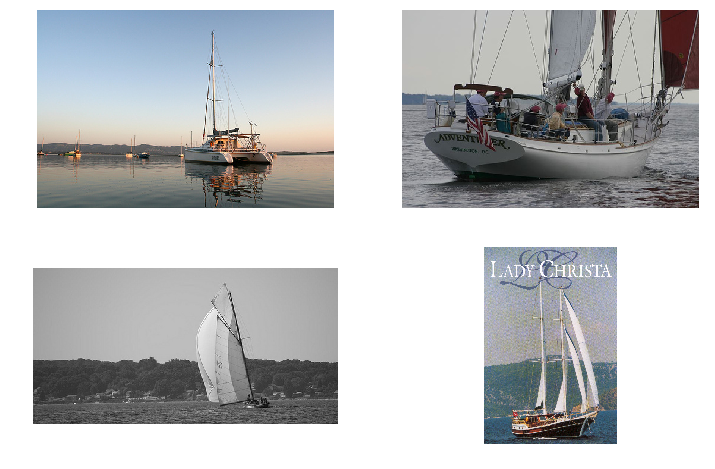

In [96]:
show_imgs_from_text('sail boat')

### Image -> Image

We can also search images with a vectors most similar to another image. This one was downloaded from Google and is definitely not in Imagenet.

In [171]:
!wget https://s7d2.scene7.com/is/image/PetSmart/AR1501_TOPIC_IMAGE-TheRightFoodToFeedYourFish-Herbivores-20160818?$AR0201$ -O images/goldfish.jpg

--2019-05-18 09:32:45--  https://s7d2.scene7.com/is/image/PetSmart/AR1501_TOPIC_IMAGE-TheRightFoodToFeedYourFish-Herbivores-20160818?$
Resolving s7d2.scene7.com (s7d2.scene7.com)... 23.38.126.126
Connecting to s7d2.scene7.com (s7d2.scene7.com)|23.38.126.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10468 (10K) [image/jpeg]
Saving to: ‘images/goldfish.jpg’

images/goldfish.jpg 100%[===================>]  10.22K  --.-KB/s    in 0s      

2019-05-18 09:32:45 (21.1 MB/s) - ‘images/goldfish.jpg’ saved [10468/10468]



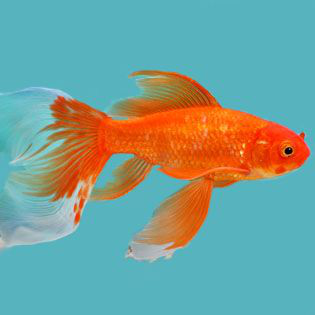

In [172]:
img = open_image('images/goldfish.jpg')
img

To get the corresdponding vector, we need to feed it to the pretrained model (`body`, defined at the top) after normalizing it.

In [173]:
img = img.data
m,s = imagenet_stats
x = (img - tensor(m)[:,None,None])/tensor(s)[:,None,None]

In [174]:
activs = body.eval()(x[None].cuda())

In [175]:
pred = learn.model.eval()(activs)

In [176]:
pred = pred[0].detach().cpu().numpy()

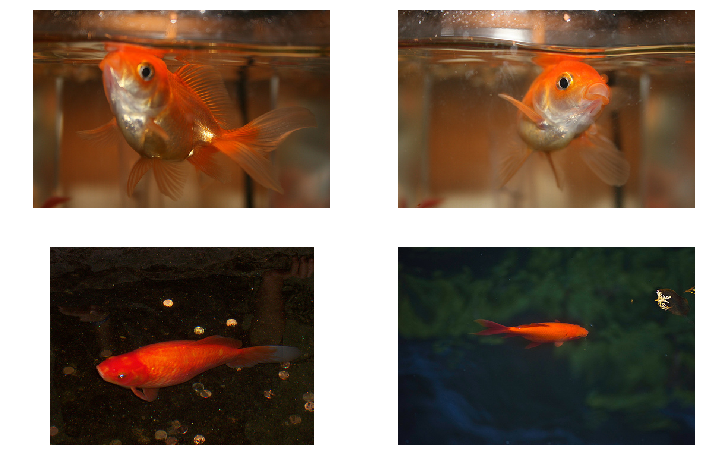

In [177]:
idxs,dists = get_knn(nn_preds, pred)
_,axs = plt.subplots(2,2,figsize=(12,8))
for i,ax in zip(idxs[:4], axs.flatten()):
    open_image(valid_names[i]).show(ax = ax)

# End